In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from statsmodels.imputation.mice import MICEData

In [19]:
data = pd.read_csv('final_data.csv')
print(data.shape)
print(data.dtypes)
data.head(3)

(7136, 13)
Name              object
Position          object
Height           float64
Weight             int64
40 Yard Dash     float64
Bench Press      float64
Vertical Jump    float64
Broad Jump       float64
Shuttle          float64
3 Cone           float64
Draft Round      float64
Draft Rank       float64
Drafted            int64
dtype: object


,Name,Position,Height,Weight,40 Yard Dash,Bench Press,Vertical Jump,Broad Jump,Shuttle,3 Cone,Draft Round,Draft Rank,Drafted
0,Derek Abney,WR,69.3,179,NaN,NaN,33.5,120.0,4.08,6.89,244.0,7.0,1
1,Nathaniel Adibi,DE,75.3,254,NaN,NaN,33.0,118.0,4.36,NaN,145.0,5.0,1
2,Roc Alexander,CB,71.0,185,NaN,NaN,39.5,125.0,4.23,6.97,NaN,NaN,0


In [20]:
### dropping name and saving it for later
names = data['Name']
data.drop('Name',axis=1,inplace=True)

In [21]:
### Attempting to determine different ways to imput missing values.
### As seen in the NFL Combine Visualization and Data Cleaning, 
### there are a few options I will be exploring.
data.isna().sum()

Position            0
Height              0
Weight              0
40 Yard Dash     1813
Bench Press      3336
Vertical Jump    2919
Broad Jump       2974
Shuttle          3515
3 Cone           3661
Draft Round      3836
Draft Rank       3836
Drafted             0
dtype: int64

In [22]:
# 1. Imputing based on position - loop through columns and impute based on median values by position
test = data.groupby(['Position'])['Shuttle'].median()
test.head()

Position
C      4.63
CB     4.15
DE     4.41
DT     4.65
EDG    4.36
Name: Shuttle, dtype: float64

In [23]:
### create copy
data_imputed_by_position = data.copy()
### now loop through list of columns to impute
columns_to_impute = ['Height','Weight','40 Yard Dash','Bench Press',
                     'Vertical Jump','Broad Jump','Shuttle','3 Cone']
for col in columns_to_impute:
    data_imputed_by_position[col] = data_imputed_by_position.groupby(['Position'])[col]\
                                    .transform(lambda x: x.fillna(x.median()))

data_imputed_by_position.isna().sum()

Position            0
Height              0
Weight              0
40 Yard Dash        0
Bench Press         0
Vertical Jump       0
Broad Jump          0
Shuttle             0
3 Cone              0
Draft Round      3836
Draft Rank       3836
Drafted             0
dtype: int64

In [31]:
# 2. Imputing based on KNN
### create copy
data_imputed_by_KNN_df = data[columns_to_impute].copy()
imputer = KNNImputer(n_neighbors=2)
data_imputed_by_KNN = imputer.fit_transform(data_imputed_by_KNN_df)
data_imputed_by_KNN = pd.DataFrame(data_imputed_by_KNN,
                                  columns=data_imputed_by_KNN_df.columns)
data_imputed_by_KNN.isna().sum()

Height           0
Weight           0
40 Yard Dash     0
Bench Press      0
Vertical Jump    0
Broad Jump       0
Shuttle          0
3 Cone           0
dtype: int64

In [44]:
# 3. Imputing based on MICE
### create copy
data_imputed_by_MICE_df = data[columns_to_impute].copy()
data_imputed_by_MICE = MICEData(data_imputed_by_MICE_df,k_pmm=3).data
data_imputed_by_MICE.head()

,Height,Weight,40 Yard Dash,Bench Press,Vertical Jump,Broad Jump,Shuttle,3 Cone
0,69.3,179,0.000239,0.166842,33.5,120.0,4.08,6.890000
1,75.3,254,0.000239,0.166842,33.0,118.0,4.36,0.003232
2,71.0,185,0.000239,0.166842,39.5,125.0,4.23,6.970000
3,72.0,210,0.000239,0.166842,32.0,114.0,4.43,7.410000
4,78.0,265,0.000239,13.000000,33.0,120.0,4.34,7.110000


In [33]:
# 4. Imputing based on simple median
### create copy
data_imputed_by_median_df = data[columns_to_impute].copy()
imputer = SimpleImputer(strategy='median')
data_imputed_by_median = imputer.fit_transform(data_imputed_by_median_df)
data_imputed_by_median = pd.DataFrame(data_imputed_by_median,
                                  columns=data_imputed_by_median_df.columns)
data_imputed_by_median.isna().sum()

Height           0
Weight           0
40 Yard Dash     0
Bench Press      0
Vertical Jump    0
Broad Jump       0
Shuttle          0
3 Cone           0
dtype: int64

In [38]:
### check resulting distributions
check_imputations = {'data_imputed_by_position':data_imputed_by_position['40 Yard Dash'],
                     'data_imputed_by_KNN':data_imputed_by_KNN['40 Yard Dash'],
                     'data_imputed_by_MICE':data_imputed_by_MICE['40 Yard Dash'],
                     'data_imputed_by_median':data_imputed_by_median['40 Yard Dash']}
check_imputations = pd.DataFrame(check_imputations)
check_imputations = check_imputations.melt(var_name='columns')
check_imputations.head()

,columns,value
0,data_imputed_by_position,4.52
1,data_imputed_by_position,4.84
2,data_imputed_by_position,4.50
3,data_imputed_by_position,4.55
4,data_imputed_by_position,4.84


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


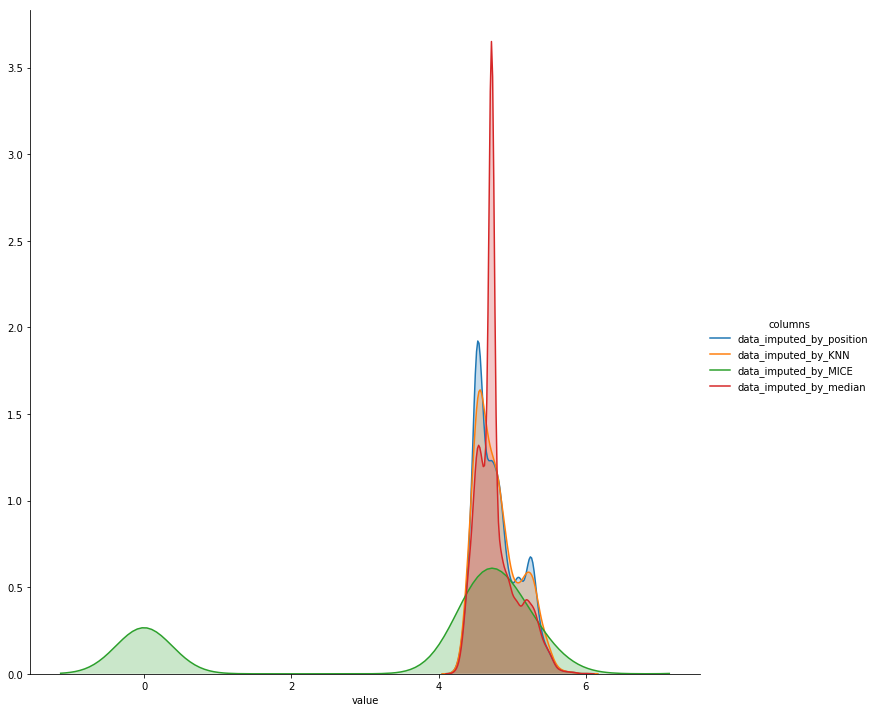

In [40]:
(sns
  .FacetGrid(check_imputations, 
             hue='columns',
             height=10)
  .map(sns.kdeplot, 'value', shade=True)
 .add_legend()
)

In [41]:
### check resulting distributions
check_imputations = {'data_imputed_by_position':data_imputed_by_position['Bench Press'],
                     'data_imputed_by_KNN':data_imputed_by_KNN['Bench Press'],
                     'data_imputed_by_MICE':data_imputed_by_MICE['Bench Press'],
                     'data_imputed_by_median':data_imputed_by_median['Bench Press']}
check_imputations = pd.DataFrame(check_imputations)
check_imputations = check_imputations.melt(var_name='columns')
check_imputations.head()

,columns,value
0,data_imputed_by_position,14.0
1,data_imputed_by_position,24.0
2,data_imputed_by_position,15.0
3,data_imputed_by_position,19.0
4,data_imputed_by_position,13.0


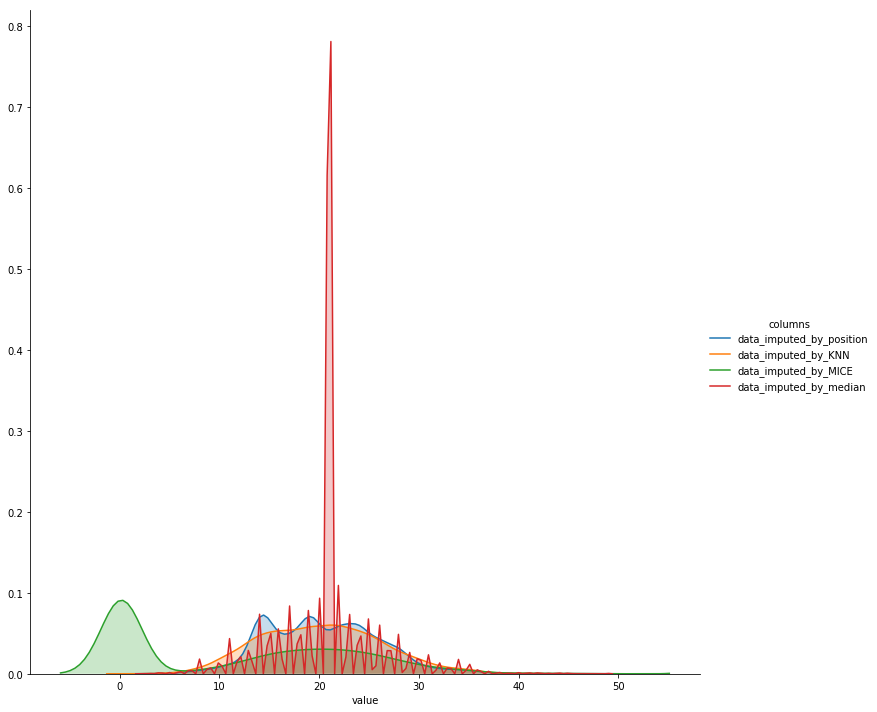

In [42]:
(sns
  .FacetGrid(check_imputations, 
             hue='columns',
             height=10)
  .map(sns.kdeplot, 'value', shade=True)
 .add_legend()
)

In [64]:
### imputation by MICE and median appear to be much worse than by position median and KNN
### write pipeline class to allow imputation strategy to be a tunable parameter
from sklearn.base import TransformerMixin, BaseEstimator
class CustomImputer(TransformerMixin, BaseEstimator):
    def __init__(self, imputeMethod = 'GroupMedian', columns_to_impute=['Height','Weight','40 Yard Dash',
                    'Bench Press','Vertical Jump','Broad Jump','Shuttle','3 Cone']):
        """
        """
        self.imputeMethod = imputeMethod
        self.columns_to_impute = columns_to_impute
    def fit(self, X, y=None):  
        return self
    def transform(self, X, y=None):
        if self.imputeMethod=='GroupMedian':
            for col in self.columns_to_impute:
                X[col] = X.groupby(['Position'])[col].transform(lambda x: x.fillna(x.median()))
        elif self.imputeMethod=='KNN':
            X = KNNImputer(n_neighbors=2).fit_transform(X[self.columns_to_impute])
        elif self.imputeMethod=='Simple':
            X = SimpleImputer(strategy='median').fit_transform(X[self.columns_to_impute])
        else:
            print("""Not a valid imputation strategy. 
            Please enter 'GroupMedian','KNN', or 'Simple'""")

        return X

In [65]:
test = CustomImputer(imputeMethod='test').fit_transform(data)

Not a valid imputation strategy. 
            Please enter 'GroupMedian','KNN', or 'Simple'
